## Merge all prepocessed data to start analysis


In [60]:
# connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [199]:
# import necessary libraries
import pandas as pd
import glob
import os

path = '/content/drive/MyDrive/2022.05.24_Final-Project_Shared-Folder/classified/reviewed'

# use glob to get all the csv files in the folder
csv_files = glob.glob(os.path.join(path, "*.csv"))
    
# loop over the list of csv files
df_files = (pd.read_csv(f) for f in csv_files)
# concat to one dataframe
df = pd.concat(df_files, ignore_index=True)
# reset the index of final DataFrame
df.reset_index(inplace = True, drop = True)
# drop columns not important for the analysis
df.drop(['Unnamed: 0', 'review', 'classification_title'], axis = 1, inplace = True)

In [200]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725 entries, 0 to 724
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           725 non-null    object
 1   country         725 non-null    object
 2   summary         725 non-null    object
 3   classification  725 non-null    object
 4   language        725 non-null    object
 5   topic           725 non-null    object
 6   link            725 non-null    object
 7   published_date  725 non-null    object
dtypes: object(8)
memory usage: 45.4+ KB
None


In [201]:
# make classification also numerical
df['classification_num'] = df['classification'].apply(lambda x: 1 if x == 'POSITIVE' else 0)
# drop countries where there are to few results
df = df.drop(df[((df.country == "unknown") | (df.country == "GB") | (df.country == "SG")| (df.country == "IS") |(df.country == "Syria") | (df.country == "SA") | (df.country == "SY") | (df.country == "VI"))].index)
# fix country names
df["country"] = df["country"].apply(lambda x: "AE" if x == 'UAE' else x)
df["country"] = df["country"].apply(lambda x: "EG" if x == 'Egypt' else x)
# drop duplicates if there are any
df.drop_duplicates(inplace = True)
# display info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 689 entries, 0 to 723
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               689 non-null    object
 1   country             689 non-null    object
 2   summary             689 non-null    object
 3   classification      689 non-null    object
 4   language            689 non-null    object
 5   topic               689 non-null    object
 6   link                689 non-null    object
 7   published_date      689 non-null    object
 8   classification_num  689 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 53.8+ KB


In [202]:
# trim the publishing date 
#df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize() # this one keeps the time but sets it to 00:00:00
df['published_date'] = pd.to_datetime(df['published_date']).dt.date
df.sort_values(by='published_date', inplace=True)

In [65]:
# save dataframe to csv
df.to_csv(f"/content/drive/MyDrive/2022.05.24_Final-Project_Shared-Folder/final_dataset.csv")

## Do some basic analytics

main analysis should be done in Tablou though, to practise that tool as well

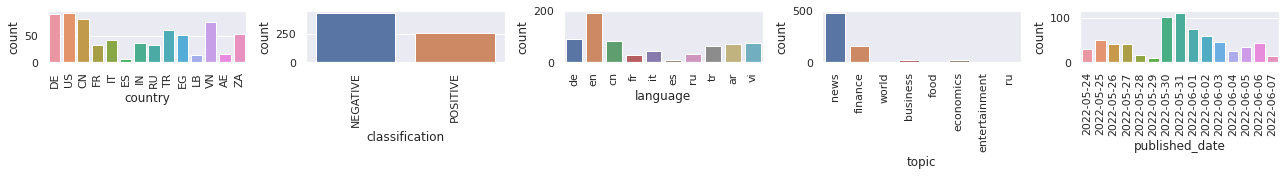

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# exclude some columns first
plot_df = df.drop(['link', 'summary', 'title', 'classification_num'], axis = 1)


fig = plt.figure(figsize=(18,20))
for index in range(len(plot_df.columns)):
    plt.subplot(9,5,index+1)
    sns.countplot(x=plot_df.iloc[:,index], data=plot_df.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

In [204]:
gf = df[["classification", "country", "title"]].groupby(["country", "classification"]).count()
gf

title
country classification       
AE      NEGATIVE           13
        POSITIVE            2
CN      NEGATIVE           49
        POSITIVE           33
DE      NEGATIVE           38
        POSITIVE           53
EG      NEGATIVE           44
        POSITIVE            7
ES      NEGATIVE            4
        POSITIVE            3
FR      NEGATIVE           20
        POSITIVE           13
IN      NEGATIVE           20
        POSITIVE           17
IT      NEGATIVE           32
        POSITIVE           11
LB      NEGATIVE            7
        POSITIVE            7
RU      NEGATIVE           24
        POSITIVE            8
TR      NEGATIVE           50
        POSITIVE           12
US      NEGATIVE           58
        POSITIVE           35
VN      NEGATIVE           60
        POSITIVE           16
ZA      NEGATIVE           15
        POSITIVE           38

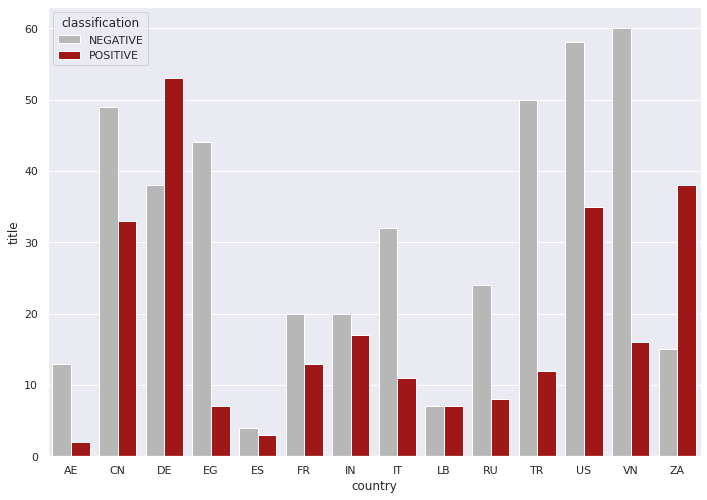

In [205]:
# need reset_index() so values can be ploted 
new = df[["classification", "country","title"]].groupby(["country", "classification"]).count().reset_index()

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='country',y='title',hue='classification',data=new, palette=["#b7b7b7", "#b70000"])


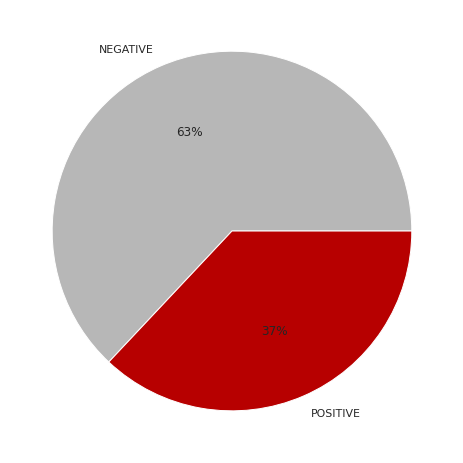

In [206]:
#define data
data = df.classification.value_counts()
labels = ["NEGATIVE", "POSITIVE"]

#define Seaborn color palette to use
colors = ["#b7b7b7", "#b70000"]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

##Does the sentiment correlates with the gold price changes?

In [207]:
ddf = df[["classification", "published_date","title"]].groupby(["published_date", "classification"]).count().reset_index()

In [210]:
# while loop to calculate the ratio between POSITVE and NEGATIVE
ratio_list = []
def ratio():
  i = 0
  while i < len(ddf["title"]):
    ratio = (ddf["title"][i+1] / ddf["title"][i])
    print(ratio)
    i += 2
    ratio_list.append(ratio)
    ratio_list.append(ratio)

ratio()

1.4166666666666667
0.75
0.6666666666666666
1.5625
1.0
1.25
0.5303030303030303
0.5068493150684932
0.39622641509433965
0.6571428571428571
0.7307692307692307
0.3
0.25
0.30303030303030304
0.625


In [216]:
# insert the ratio to the DataFrame
ddf["ratio"] = ratio_list
# rename published_date => date
ddf = ddf.rename(columns={"published_date": "date"})
ddf

,date,classification,title,ratio
0,2022-05-24,NEGATIVE,12,1.416667
1,2022-05-24,POSITIVE,17,1.416667
2,2022-05-25,NEGATIVE,28,0.750000
3,2022-05-25,POSITIVE,21,0.750000
4,2022-05-26,NEGATIVE,24,0.666667
5,2022-05-26,POSITIVE,16,0.666667
6,2022-05-27,NEGATIVE,16,1.562500
7,2022-05-27,POSITIVE,25,1.562500
8,2022-05-28,NEGATIVE,8,1.000000
9,2022-05-28,POSITIVE,8,1.000000


In [212]:
import requests

# get daily gold prices

url = "https://live-and-historical-metal-prices-metalexpress.p.rapidapi.com/historical"

querystring = {"metal":"gold","interval":"daily","currency":"usd","from_date":"2022-05-24","to_date":"2022-06-07"}

headers = {
	"X-RapidAPI-Host": "live-and-historical-metal-prices-metalexpress.p.rapidapi.com",
	"X-RapidAPI-Key": "SECRET KEY"
}

response = requests.request("GET", url, headers=headers, params=querystring)

print(response.text)

[{"date":"2022-06-07","price":1852.43,"open":1839.56,"high":1855.57,"low":1837.15},{"date":"2022-06-06","price":1841.68,"open":1851.43,"high":1857.81,"low":1840.78},{"date":"2022-06-05","price":1851.62,"open":1850.65,"high":1853.38,"low":1849.95},{"date":"2022-06-03","price":1850.77,"open":1868.53,"high":1874.3,"low":1847.02},{"date":"2022-06-02","price":1868.69,"open":1846.04,"high":1870.46,"low":1844.08},{"date":"2022-06-01","price":1846.38,"open":1836.55,"high":1849.99,"low":1828.57},{"date":"2022-05-31","price":1837.57,"open":1852.44,"high":1857.24,"low":1835.21},{"date":"2022-05-30","price":1856.18,"open":1850.03,"high":1864.03,"low":1848.74},{"date":"2022-05-29","price":1849.88,"open":1852.96,"high":1854.12,"low":1848.18},{"date":"2022-05-27","price":1852.73,"open":1850.48,"high":1862.3,"low":1847.76},{"date":"2022-05-26","price":1850.82,"open":1854.06,"high":1854.44,"low":1841.58},{"date":"2022-05-25","price":1853.21,"open":1867.58,"high":1868.19,"low":1842.95},{"date":"2022-05-

In [225]:
from pandas import json_normalize

# create a new DataFrame for prices
gdf = (json_normalize(dict))
gdf.sort_values(by='date', inplace=True)
gdf.drop(["high", "low", "open"], axis = 1, inplace = True)
gdf

,date,price
12,2022-05-24,1866.49
11,2022-05-25,1853.21
10,2022-05-26,1850.82
9,2022-05-27,1852.73
8,2022-05-29,1849.88
7,2022-05-30,1856.18
6,2022-05-31,1837.57
5,2022-06-01,1846.38
4,2022-06-02,1868.69
3,2022-06-03,1850.77


In [226]:
# change the dtype to datetime in both DataFrames
gdf['date'] = pd.to_datetime(gdf['date'])
ddf['date'] = pd.to_datetime(ddf['date'])

(array([738300., 738302., 738304., 738306., 738307., 738309., 738311.,
        738313.]), <a list of 8 Text major ticklabel objects>)

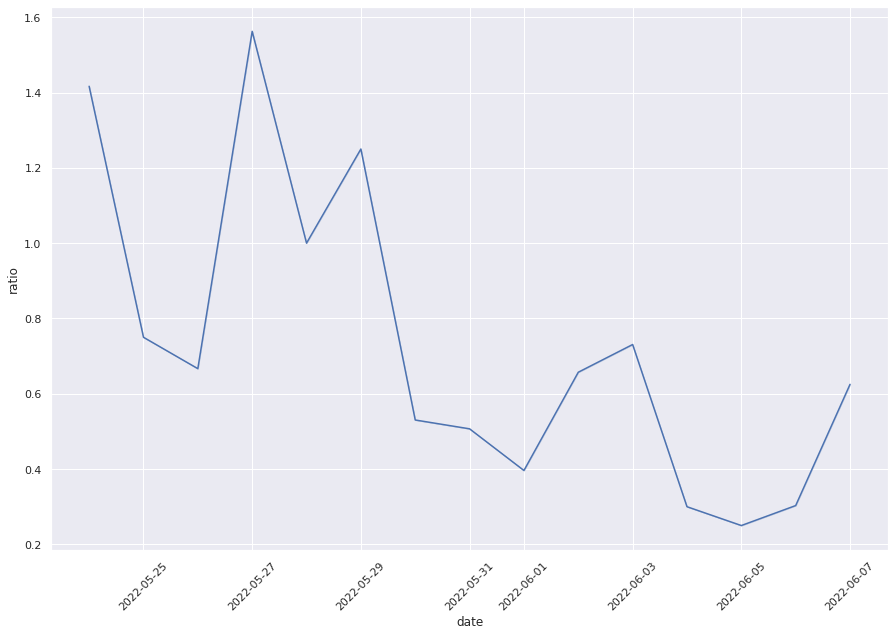

In [227]:
# plot the ratio POSITIVE / NEGATIVE
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.lineplot(x='date',y='ratio',data=ddf)
plt.xticks(rotation = 45)

(array([738300., 738302., 738304., 738306., 738307., 738309., 738311.,
        738313.]), <a list of 8 Text major ticklabel objects>)

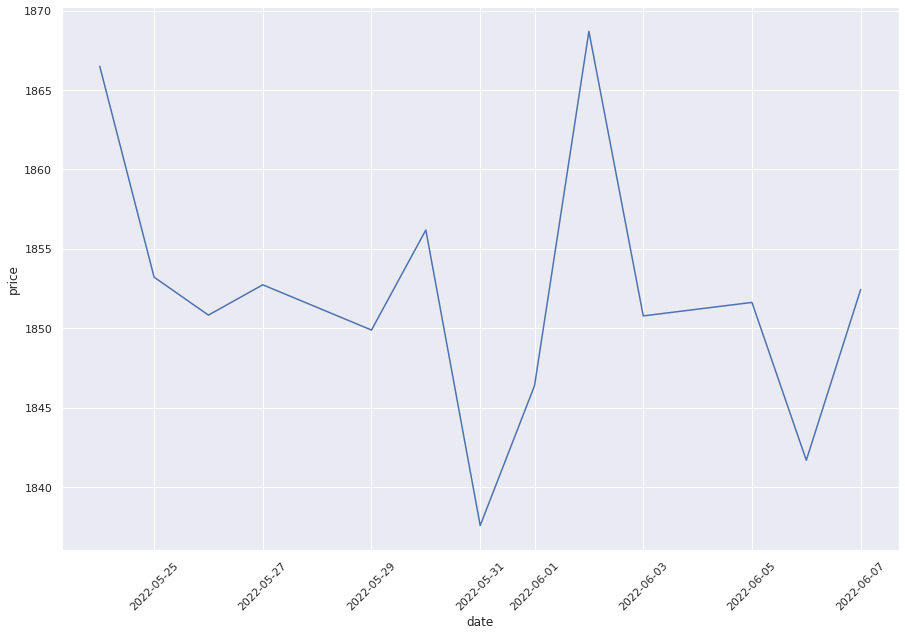

In [228]:
# plot gold price for same period
sns.set(rc={'figure.figsize':(15,10)})
ax = sns.lineplot(x='date',y='price',data=gdf)
plt.xticks(rotation = 45)

In [ ]:
# create a combined DataFrame
merged_df = pd.merge(gdf, ddf, on='date', how='outer')
# sort the values by date
merged_df.sort_values(by='date', inplace=True)
# fill missing values
merged_df["price"] = merged_df["price"].fillna(method='ffill')
merged_df

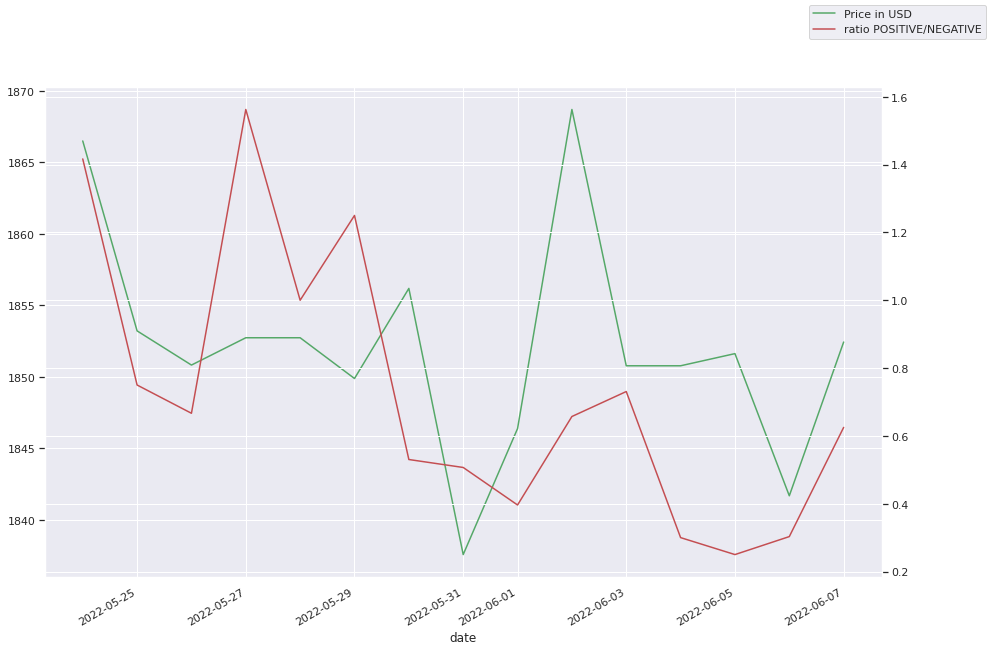

In [258]:
# plot the ratio against the price
sns.set(rc={'figure.figsize':(15,10)})

ax = merged_df.plot(x="date", y="price", legend=False, color="g", label="Price in USD")
ax2 = ax.twinx()
merged_df.plot(x="date", y="ratio", ax=ax2, legend=False, color="r", label="ratio POSITIVE/NEGATIVE")
ax.figure.legend()
plt.show()